# Exam: Exercise 6 - Dormand Prince 5(4)

### 6.1 Description and Stability

In [3]:
import numpy as np
import matplotlib.pyplot as plt

s, p = 7, 4 # stages s; order p

# Coefficients for Dormand-Prince method
c2, c3, c4, c5, c6, c7 = 1/5, 3/10, 4/5, 8/9, 1, 1
a21 = 1/5
a31, a32 = 3/40, 9/40
a41, a42, a43 = 44/45, -56/15, 32/9
a51, a52, a53, a54 = 19372/6561, -25360/2187, 64448/6561, -212/729
a61, a62, a63, a64, a65 = 9017/3168, -355/33, 46732/5247, 49/176, -5103/18656
a71, a72, a73, a74, a75, a76 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84

b1, b2, b3, b4, b5, b6, b7 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0
b1p, b2p, b3p, b4p, b5p, b6p, b7p = 5179/57600, 0, 7571/16695, 393/640, -92097/339200, 187/2100, 1/40

# coefficient matrices and vectors
A = np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [a21, 0, 0, 0, 0, 0, 0],
    [a31, a32, 0, 0, 0, 0, 0],
    [a41, a42, a43, 0, 0, 0, 0],
    [a51, a52, a53, a54, 0, 0, 0],
    [a61, a62, a63, a64, a65, 0, 0],
    [a71, a72, a73, a74, a75, a76, 0],
])

c = np.array([0, c2, c3, c4, c5, c6, c7]).reshape(-1,1)
b = np.array([b1, b2, b3, b4, b5, b6, b7]).reshape(-1,1)
b_ = np.array([b1p, b2p, b3p, b4p, b5p, b6p, b7p]).reshape(-1,1)
e = np.array([71/57600,  0, -71/16695, 71/1920, -17253/339200, 22/525, -1/40]).reshape(-1,1)

In [111]:
# R(z) = 1 + z b^T(Id - z A)^{-1} e

re = np.linspace(-5, 5, 500)
im = np.linspace(-5, 5, 500)
rev, imv = np.meshgrid(re, im)

z = np.array([complex(r,i) for r, i in zip(rev.flatten(), imv.flatten())]).reshape(500, 500)
R = lambda z: 1 + np.inner(z,b.T)@np.linalg.inv(np.eye(len(A)) - z*A)@e
R = lambda z: 1 + np.inner(z,b.T)@np.linalg.inv(np.eye(len(A)) - z*A)@np.ones(len(A))
#R = lambda z: 1 + np.inner(z,b.T)@np.linalg.solve((np.eye(len(A))-z*A), np.ones(len(b)))
Rz = np.array([R(z_) for z_ in z.flatten()])

For $R(z)$ two formulas are given. One in math writing p.25 and one in a **matlab** implementation p.26-27 (in *Lecture 8B*)

1. $R(z) = 1 + z b^T(Id - z A)^{-1} e$
2. $R(z) = 1 + z b^T ((Id - z A) \Delta \mathbf{1})$

where $\Delta$ is the 'solve for ...' operator, hence $A \Delta b = x$ comes from $Ax = b \Leftrightarrow x = A^{-1}b$. 

But the two equations are not mathematically equivalent and yield very different results for a stability analysis.

Which one is the correct one then?

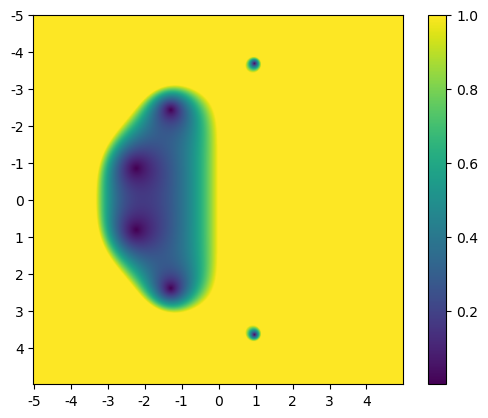

In [112]:
plt.imshow(np.abs(Rz.reshape(500,500)).clip(max=1))
plt.colorbar()
plt.xticks(ticks=np.arange(0, 500, 50), labels=np.arange(-5,5,1));
plt.yticks(ticks=np.arange(0, 500, 50), labels=np.arange(-5,5,1));
#plt.yticks(np.arange(-5, 5, 1))

In [204]:
def RK_stability(A:np.ndarray, b:np.ndarray, err_vec:np.ndarray, grid_size:int=5, pixels:int=500) -> tuple:
    x, y = np.linspace(-grid_size, grid_size, pixels), np.linspace(-grid_size, grid_size, pixels)
    X, Y = np.meshgrid(x, y)
    Z = X + 1j*Y

    absR, absEhat, absEhatmE, absE, absF = [], [], [], [], []
    for z in Z.flatten():
        A_inv_ = np.linalg.solve((np.eye(len(A))-z*A), np.ones(len(b)))
        R = 1+np.inner(z,b.T)@A_inv_
        Ehat = np.inner(z,err_vec.T)@A_inv_
        E = R-np.exp(z)
        absR.append(np.abs(R))
        absEhat.append(np.abs(Ehat))
        absEhatmE.append(np.abs(Ehat-E))
        absE.append(np.abs(E))
        absF.append(np.abs(np.exp(z)))
    absR = np.array(absR).reshape(pixels, pixels)
    absEhat = np.array(absEhat).reshape(pixels, pixels)
    absEhatmE = np.array(absEhatmE).reshape(pixels, pixels)
    absE = np.array(absE).reshape(pixels, pixels)
    absF = np.array(absF).reshape(pixels, pixels)
    
    return absR, absEhat, absEhatmE, absE, absF

def plot_rk_stability(A:np.ndarray, b:np.ndarray, err_vec:np.ndarray, method_name:str=None, grid_size:int=5, pixels:int=500):
    absR, absEhat, absEhatmE, absE, absF = RK_stability(A, b, err_vec, grid_size, pixels)

    fig = plt.figure(figsize=(10,4), dpi=400)
    if method_name!=None:
        fig.suptitle(f"Stability for {method_name}")
    ax1 = plt.subplot2grid(shape=(2, 4), loc=(0, 0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid(shape=(2, 4), loc=(0, 2))
    ax3 = plt.subplot2grid(shape=(2, 4), loc=(0, 3))
    ax4 = plt.subplot2grid((2, 4), (1, 2))
    ax5 = plt.subplot2grid((2, 4), (1, 3))

    ax1.set_title('$|R(z)|$')
    ax1.imshow(absR.clip(max=1))
    ax1.axvline(pixels//2, color='r')
    ax1.axhline(pixels//2, color='r')
    ax1.set_xticks(ticks=np.arange(0, pixels, 50), labels=np.arange(-grid_size, grid_size,1))
    ax1.set_yticks(ticks=np.arange(0, pixels, 50), labels=np.arange(-grid_size, grid_size,1))
    ax1.set_xlabel("$Re(z)$")
    ax1.set_ylabel("$Im(z)$")

    ax2.set_title('$|\hat{E}(z)|$')
    ax2.set_xticks(ticks=np.arange(0, pixels, 50), labels=[])
    ax2.set_yticks(ticks=np.arange(0, pixels, 50), labels=[])
    ax2.axvline(pixels//2, color='r')
    ax2.axhline(pixels//2, color='r')
    ax2.imshow(absEhat.clip(max=1))

    ax3.set_title('$|exp(z)|$')
    ax3.set_xticks(ticks=np.arange(0, pixels, 50), labels=[])
    ax3.set_yticks(ticks=np.arange(0, pixels, 50), labels=[])
    ax3.axvline(pixels//2, color='r')
    ax3.axhline(pixels//2, color='r')
    ax3.imshow(absF.clip(max=1))
    
    ax4.set_title('$|E(z)|$')
    ax4.set_xticks(ticks=np.arange(0, pixels, 50), labels=[])
    ax4.set_yticks(ticks=np.arange(0, pixels, 50), labels=[])
    ax4.axvline(pixels//2, color='r')
    ax4.axhline(pixels//2, color='r')
    ax4.imshow(absE.clip(max=1))

    ax5.set_title('$|E(z) - \hat{E}(z)|$')
    ax5.set_xticks(ticks=np.arange(0, pixels, 50), labels=[])
    ax5.set_yticks(ticks=np.arange(0, pixels, 50), labels=[])
    ax5.axvline(pixels//2, color='r')
    ax5.axhline(pixels//2, color='r')
    ax5.imshow(absEhatmE.clip(max=1))

    #fig.subplots_adjust(right=0.8, hspace=0.1, wspace=0.1)
    fig.subplots_adjust(hspace=0.25)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    #fig.colorbar(plt.imshow(absR.clip(max=1)), cax=cbar_ax)
    fig.colorbar(plt.imshow(absE.clip(max=1)), ax=ax1)

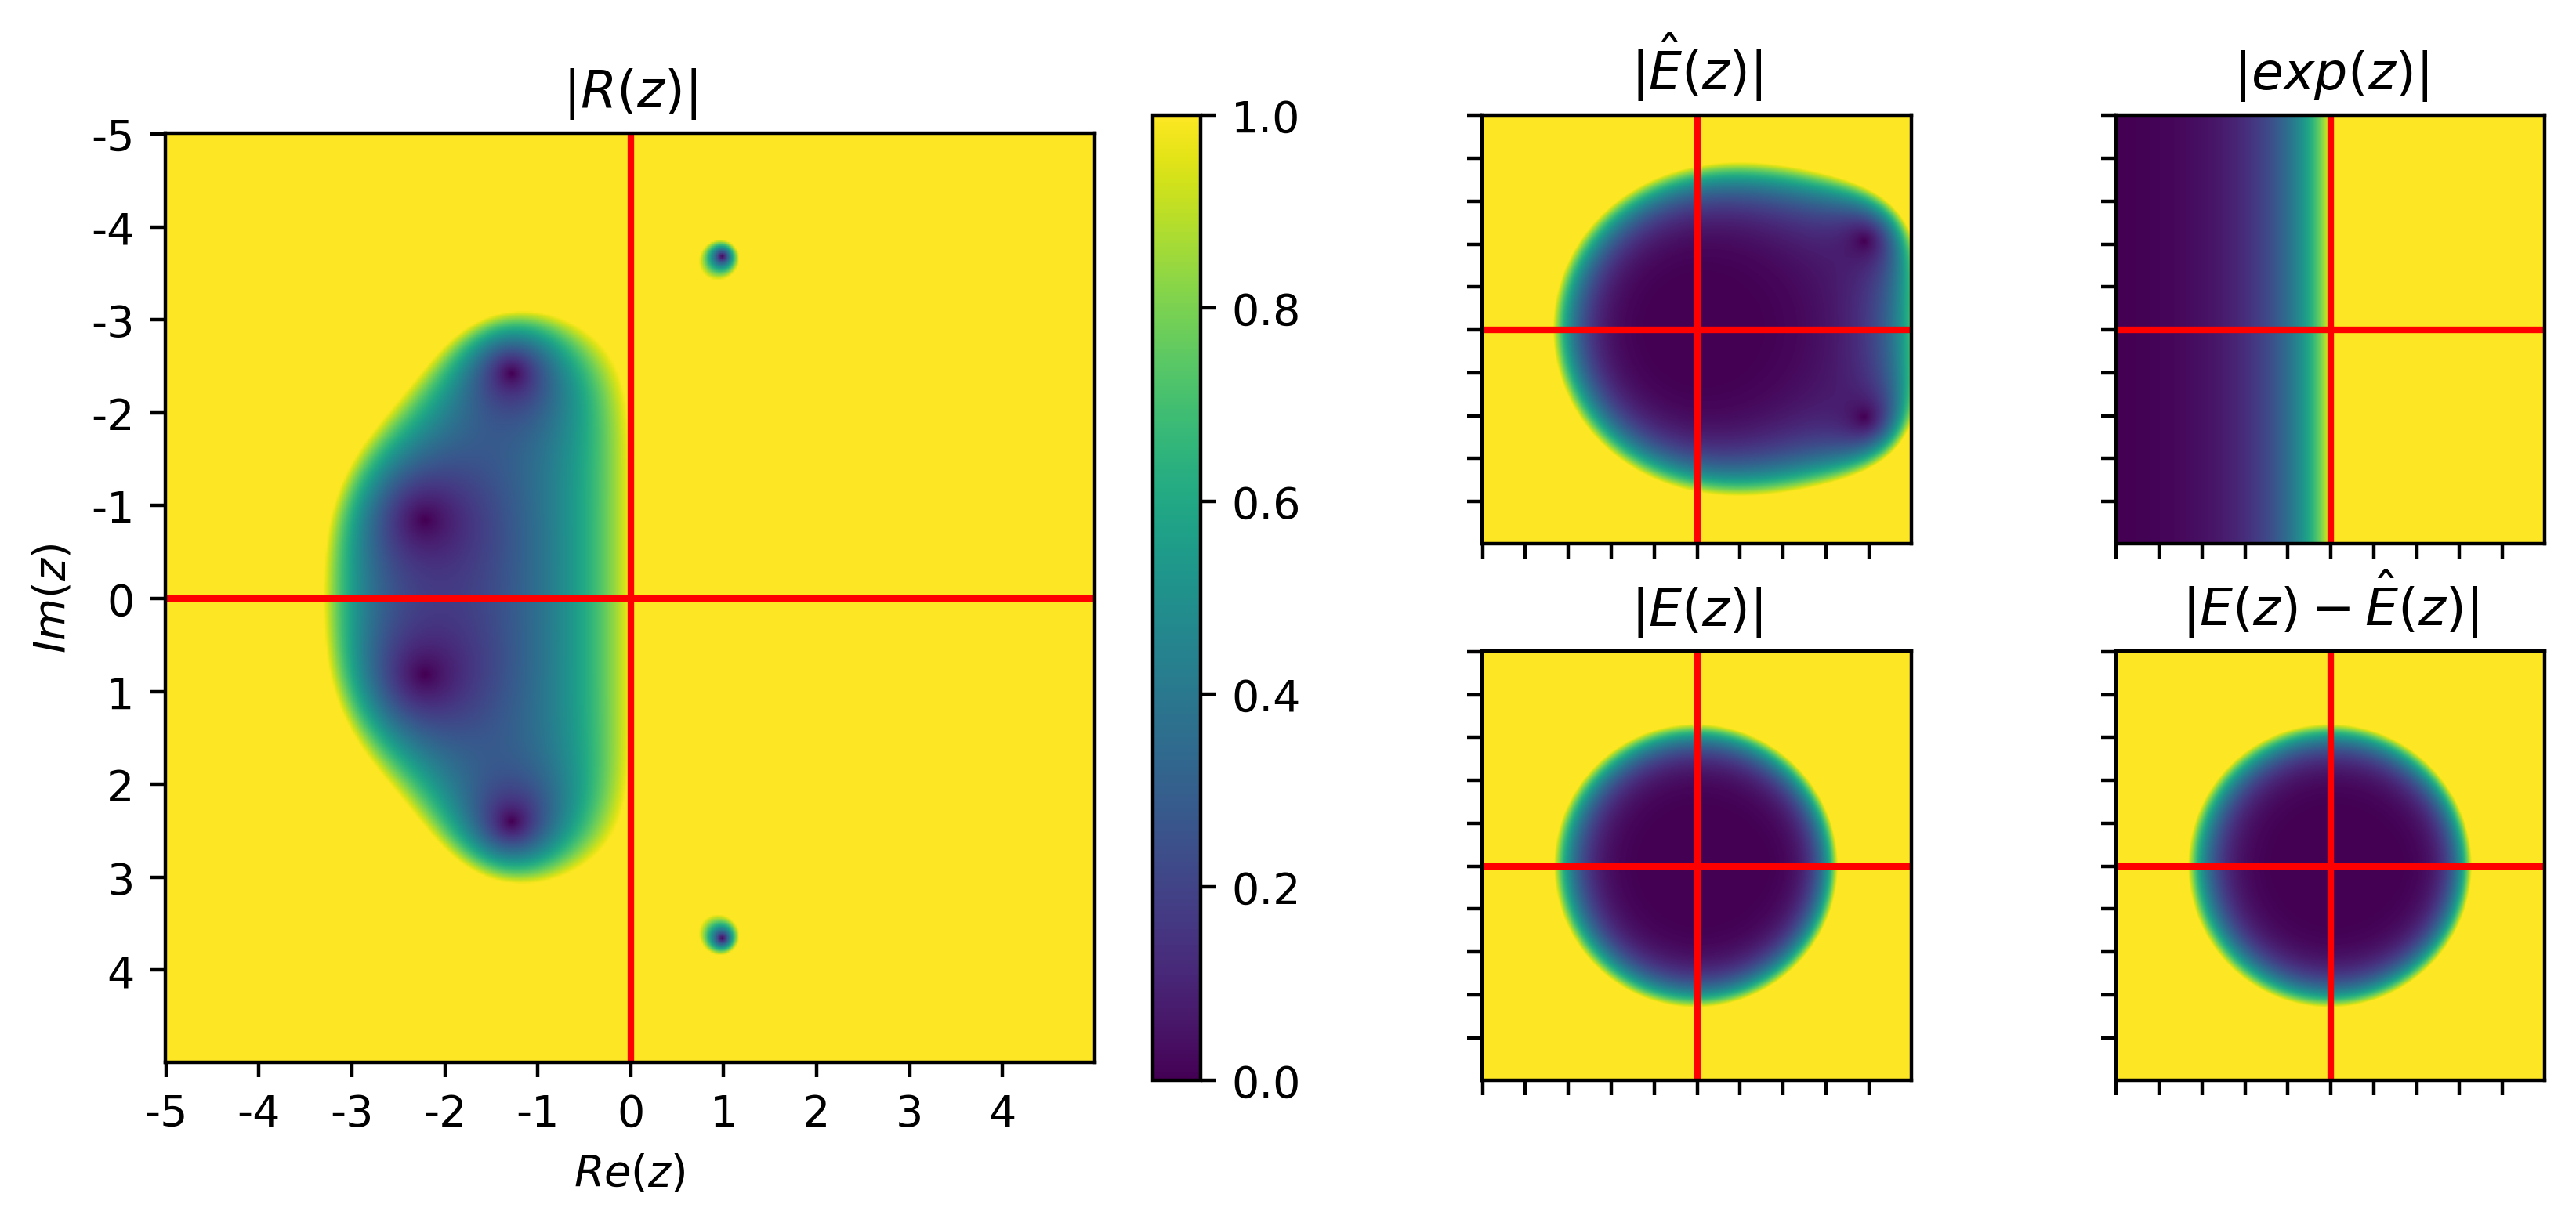

In [206]:
#plot_rk_stability(A, b, e, "DOPRI(5)4")
plot_rk_stability(A, b, e)

### 6.2 Adaptive stepsize implementation

In [232]:
def dormand_prince_step(f, t, x, h):

    # Runge-Kutta Explicit Order 4

    # Coefficients for Dormand-Prince method
    c2, c3, c4, c5, c6, c7 = 1/5, 3/10, 4/5, 8/9, 1, 1
    a21 = 1/5
    a31, a32 = 3/40, 9/40
    a41, a42, a43 = 44/45, -56/15, 32/9
    a51, a52, a53, a54 = 19372/6561, -25360/2187, 64448/6561, -212/729
    a61, a62, a63, a64, a65 = 9017/3168, -355/33, 46732/5247, 49/176, -5103/18656
    a71, a72, a73, a74, a75, a76 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84
    
    b1, b2, b3, b4, b5, b6, b7 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0
    b1p, b2p, b3p, b4p, b5p, b6p, b7p = 5179/57600, 0, 7571/16695, 393/640, -92097/339200, 187/2100, 1/40

    # Calculate the stages
    k1 = h * f(t, x)
    k2 = h * f(t + c2*h, x + a21*k1)
    k3 = h * f(t + c3*h, x + a31*k1 + a32*k2)
    k4 = h * f(t + c4*h, x + a41*k1 + a42*k2 + a43*k3)
    k5 = h * f(t + c5*h, x + a51*k1 + a52*k2 + a53*k3 + a54*k4)
    k6 = h * f(t + c6*h, x + a61*k1 + a62*k2 + a63*k3 + a64*k4 + a65*k5)
    k7 = h * f(t + c7*h, x + a71*k1 + a72*k2 + a73*k3 + a74*k4 + a75*k5 + a76*k6)

    # Compute the next value
    x_next = x + b1*k1 + b2*k2 + b3*k3 + b4*k4 + b5*k5 + b6*k6 + b7*k7

    # Estimate error with embedded method
    x_err = abs(b1p*k1 + b2p*k2 + b3p*k3 + b4p*k4 + b5p*k5 + b6p*k6 + b7p*k7 - x_next)

    return x_next, x_err


def adaptive_dopri54(f, x0, t0:float=0.0, t_end:float=10.0, h:float=0.3, eps:float=0.8, *args):
    """
    f[func]:            function of the ODE
    y0[list]:           initial condition/value
    t0[float]:          start time
    t_end[float]        end_time
    h[float]=0.1:       step_size, delta_t
    tol[float]=1e-6:    tolerance for adaptive step size

    returns
        np.array: timesteps, np.array: solution_vector

    warning:
        Too High Initial Step Size or Tolerance: If the initial step size (`h`) is too large 
        compared to the problem's dynamics and tolerance (`tol`), the estimated errors could be 
        consistently above acceptable levels without reducing `h`.
        => increase tolarance
    """

    # Adaptive Runge-Kutta 4(5) integration
    t = t0
    x = np.array(x0)
    times = [t]
    results = [x.copy()]
    err = [0]
    p = 4                       # integrator order
    k_p = 0.4/(p+1)
    k_i = 0.3/(p+1)
    r_acc = 1

    while t < t_end:
        if t + h > t_end:  # Adjust last step to reach exactly t_end
            h = t_end - t

        x_next, err_est = dormand_prince_step(f, t, x, h)

        # Estimate the error and adjust step size
        r = np.linalg.norm(err_est, ord=2)
        err.extend(err_est)
        
        if r <= 1.0:
            t += h
            x = x_next
            times.append(t)
            results.append(x.copy())
            h *= ((eps/r)**k_i)*((r_acc/r)**k_p)
            r_acc = r
        
        else:
            h *= (eps/r)**(1/p)

    return np.array(times), np.array(results), np.array(err)

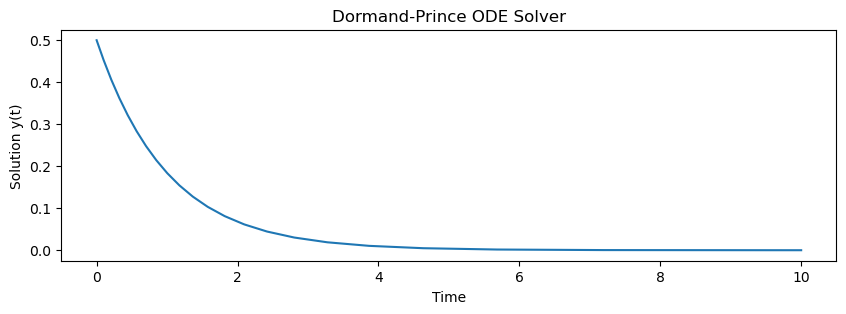

In [233]:
import matplotlib.pyplot as plt

def test_equation(t, x, lambda_:float=-1.0):
    dxdt = lambda_*x
    return dxdt

t0, y0, t_end = 0.0, [0.5], 10.0
times, results, err_est = adaptive_dopri54(test_equation, y0, t0, t_end, h=0.1, eps=0.8)

plt.figure(figsize=(10,3))
plt.plot(times, results)
plt.xlabel('Time')
plt.ylabel('Solution y(t)')
plt.title('Dormand-Prince ODE Solver')
plt.show()

### 6.3 DOPRI(5)4 on test problems

We don't need the Jacobians, since DOPRI54 is purely explicit.

In [ ]:
from project.models import PreyPredator, VanDerPol, CSTR3, CSTR1
from project.solver import adaptive_dopri54
import numpy as np

def test_equation(t, x, lambda_:float=-1.0):
    dxdt = lambda_*x
    return dxdt

#res = adaptive_dopri54(PreyPredator, np.array([1.0, 0.05]).reshape(-1,1), t0=0, t_end=5, h=0.0001, eps=0.2)
#res = adaptive_dopri54(test_equation, x0=[0.5], t0=0, t_end=5, h=0.1)

*Problem:*
- adaptive_dopri54 with PI error controller and 2-norm gets stuck on PredatorPray!
- actually not a stiff problem
- after print outs: the error $r$ stay slightly above 1, so all steps get rejected, but the adjustment factor is 0.9999... so it also doesn't decrease the stepsize significantly

*Solution:*
Try a different control mechanism for the step-size.

In [ ]:
from project.solver import adaptive_rk45
from project.models import PreyPredator
import numpy as np

def PreyPredator(t:float, x, params:tuple=(1, 0.8)):
    a, b = params
    x1, x2 = x
    dx1 = a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2
    return np.array([dx1, dx2])

res = adaptive_rk45(PreyPredator, np.array([1.0, 0.05]).reshape(-1,1), t0=0, t_end=5, h=0.1)

In [1]:
from project.solver import adaptive_dopri54
from project.models import PreyPredator
import numpy as np

# Initial Conditions
x0 = np.array([10.0, 5.0]).reshape(-1,1)  # [Prey, Predator]
t0, t_end = 0, 30

ts, xs, errs = adaptive_dopri54(PreyPredator, x0, control_method='limit')

KeyboardInterrupt: 

In [1]:
from project.solver import DOPRI54
from project.models import PreyPredator
import numpy as np

# Initial Conditions
x0 = np.array([10.0, 5.0]).reshape(-1,1)  # [Prey, Predator]
t0, t_end = 0, 30

def PreyPredator(t:float, x):
    a, b = 1, 0.8
    x1, x2 = x
    dx1 = a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2
    return np.array([dx1, dx2])

ts, xs, errs = DOPRI54().adaptive_solve(PreyPredator, x0)

ValueError: shapes (7,) and (7,2,1) not aligned: 7 (dim 0) != 2 (dim 1)

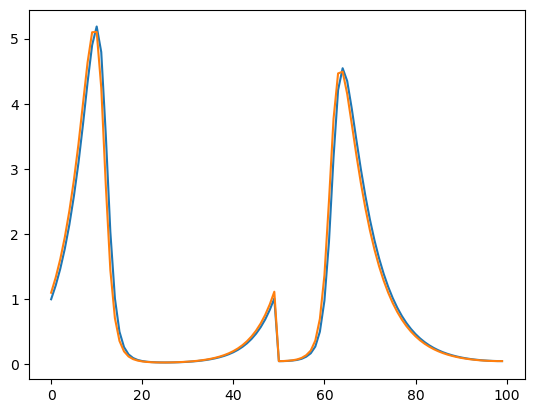

In [19]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

def PreyPredator(t:float, x, params:tuple=(1, 0.8)):
    a, b = params
    x1, x2 = x
    dx1 = a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2
    return np.array([dx1, dx2]).reshape(-1,1)

res = solve_ivp(PreyPredator, t_span=(0,10), t_eval=np.linspace(0,10,100), y0=np.array([1, 0.05]).reshape(-1,), method='RK45', vectorized=True)
plt.plot(res.y.reshape(-1, 2))

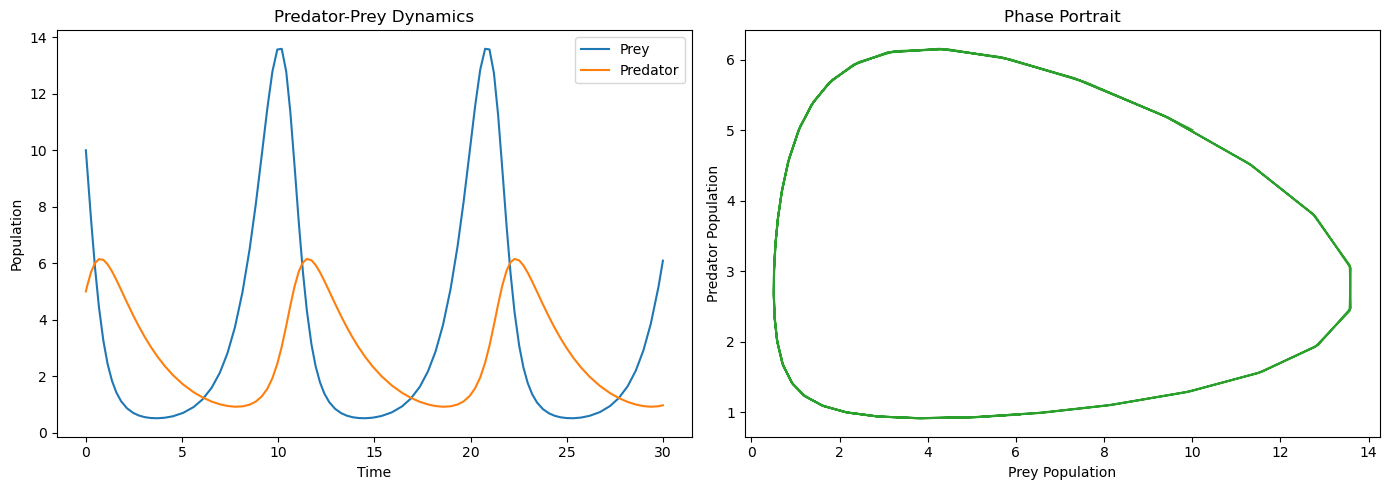

In [ ]:
# Initial Conditions
y0 = np.array([10.0, 5.0])  # [Prey, Predator]
t0, t_end = 0, 30

# Instantiate and Solve
solver = DOPRI54(lambda t, y: predator_prey(t, y))
t_vals, y_vals = solver.integrate(t0, y0, t_end)

# Plotting
plt.figure(figsize=(14, 5))

# Plot time series
plt.subplot(1, 2, 1)
plt.plot(t_vals, y_vals[:, 0], label='Prey', color='tab:blue')
plt.plot(t_vals, y_vals[:, 1], label='Predator', color='tab:orange')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Predator-Prey Dynamics')
plt.legend()

# Plot phase plot
plt.subplot(1, 2, 2)
plt.plot(y_vals[:, 0], y_vals[:, 1], color='tab:green')
plt.xlabel('Prey Population')
plt.ylabel('Predator Population')
plt.title('Phase Portrait')

plt.tight_layout()
plt.show()


In [ ]:

T0 = 273.15
C0 = np.array([1.6/2, 2.4/2, 600])
MODELS_INIT = [(PreyPredator, [1.0, 0.05]), (VanDerPol, [2.0, 0.01]), (CSTR3, C0), (CSTR1, T0)]

for model, x0 in MODELS_INIT:
    x_sol = adaptive_dopri54(model, x0=x0)
    plt.plot(x_sol)

# x0 needs to be shape (-1, 1)

_________________________________

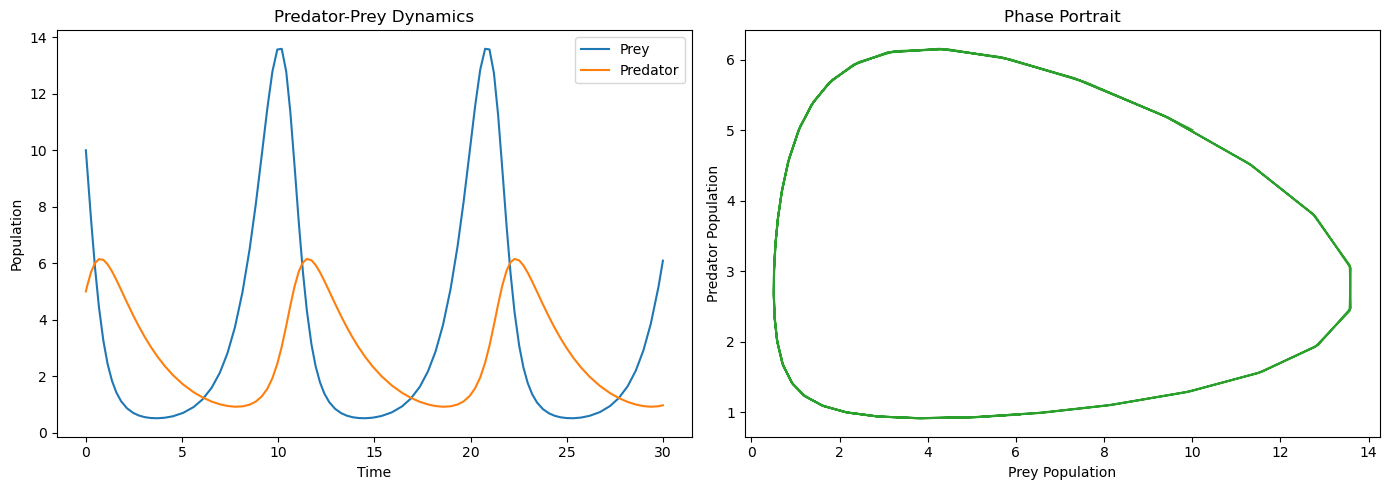

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class DOPRI54:
    def __init__(self, f, rtol=1e-6, atol=1e-9, h_init=0.01, h_min=1e-6, h_max=1.0):
        self.f = f
        self.rtol = rtol
        self.atol = atol
        self.h_min = h_min
        self.h_max = h_max
        self.h = h_init

        # Dormand-Prince coefficients (Butcher tableau)
        self.c = np.array([0, 1/5, 3/10, 4/5, 8/9, 1, 1])
        self.a = [
            [],
            [1/5],
            [3/40, 9/40],
            [44/45, -56/15, 32/9],
            [19372/6561, -25360/2187, 64448/6561, -212/729],
            [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656],
            [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84]
        ]
        self.b = np.array([35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0])
        self.b_hat = np.array([5179/57600, 0, 7571/16695, 393/640,
                               -92097/339200, 187/2100, 1/40])

    def step(self, t, y):
        k = []
        for i in range(7):
            yi = y.copy()
            for j in range(i):
                yi += self.h * self.a[i][j] * k[j]
            k.append(self.f(t + self.c[i] * self.h, yi))

        y_next = y + self.h * np.dot(self.b, k)
        y_err = self.h * np.dot(self.b - self.b_hat, k)
        err_norm = np.linalg.norm(y_err / (self.atol + self.rtol * np.abs(y_next)), ord=np.inf)
        return y_next, err_norm, k[-1]

    def integrate(self, t0, y0, tf):
        t_vals = [t0]
        y_vals = [y0]
        t = t0
        y = y0
        h = self.h

        while t < tf:
            if t + h > tf:
                h = tf - t
            self.h = h
            y_new, err_norm, dy = self.step(t, y)

            if err_norm <= 1:
                t += h
                y = y_new
                t_vals.append(t)
                y_vals.append(y)
                h = min(self.h_max, h * min(5, 0.9 * (1 / err_norm)**0.2))
            else:
                h = max(self.h_min, h * max(0.1, 0.9 * (1 / err_norm)**0.25))

        return np.array(t_vals), np.array(y_vals)


# Lotka-Volterra (Predator-Prey) System
def predator_prey(t, y, alpha=1.1, beta=0.4, delta=0.1, gamma=0.4):
    prey, predator = y
    dprey_dt = alpha * prey - beta * prey * predator
    dpredator_dt = delta * prey * predator - gamma * predator
    return np.array([dprey_dt, dpredator_dt])


# Initial Conditions
y0 = np.array([10.0, 5.0])  # [Prey, Predator]
t0, tf = 0, 30

# Instantiate and Solve
solver = DOPRI54(lambda t, y: predator_prey(t, y))
t_vals, y_vals = solver.integrate(t0, y0, tf)

# Plotting
plt.figure(figsize=(14, 5))

# Plot time series
plt.subplot(1, 2, 1)
plt.plot(t_vals, y_vals[:, 0], label='Prey', color='tab:blue')
plt.plot(t_vals, y_vals[:, 1], label='Predator', color='tab:orange')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Predator-Prey Dynamics')
plt.legend()

# Plot phase plot
plt.subplot(1, 2, 2)
plt.plot(y_vals[:, 0], y_vals[:, 1], color='tab:green')
plt.xlabel('Prey Population')
plt.ylabel('Predator Population')
plt.title('Phase Portrait')

plt.tight_layout()
plt.show()


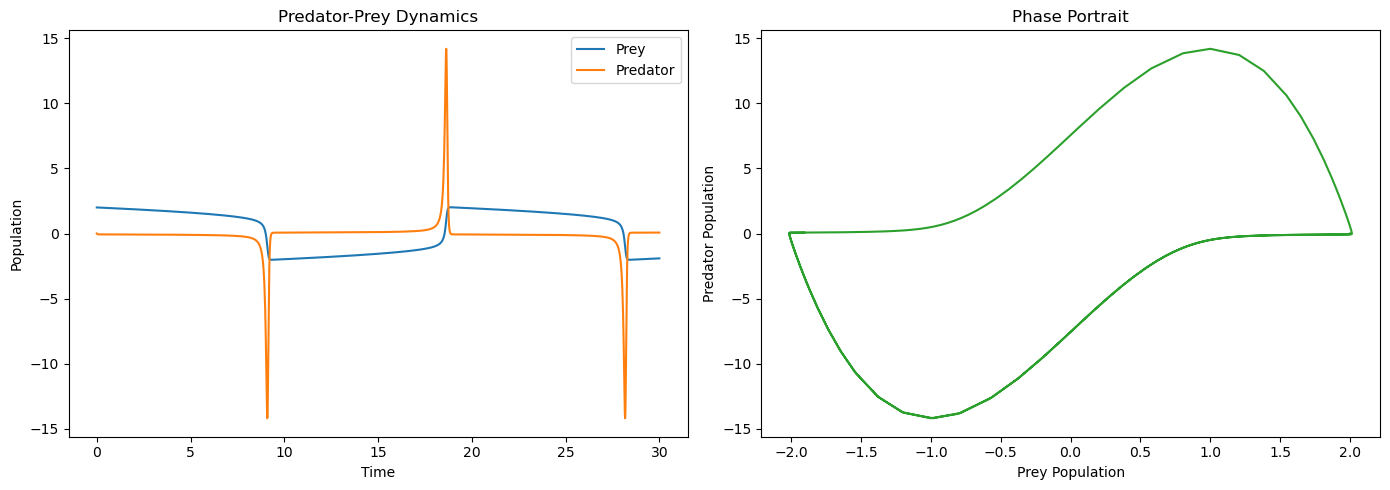

In [2]:
from project.models import VanDerPol

# Initial Conditions
y0 = np.array([2.0, 0])
t0, tf = 0, 30

# Instantiate and Solve
solver = DOPRI54(lambda t, y: VanDerPol(t, y))
t_vals, y_vals = solver.integrate(t0, y0, tf)

# Plotting
plt.figure(figsize=(14, 5))

# Plot time series
plt.subplot(1, 2, 1)
plt.plot(t_vals, y_vals[:, 0], label='Prey', color='tab:blue')
plt.plot(t_vals, y_vals[:, 1], label='Predator', color='tab:orange')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Predator-Prey Dynamics')
plt.legend()

# Plot phase plot
plt.subplot(1, 2, 2)
plt.plot(y_vals[:, 0], y_vals[:, 1], color='tab:green')
plt.xlabel('Prey Population')
plt.ylabel('Predator Population')
plt.title('Phase Portrait')

plt.tight_layout()
plt.show()

/Users/yunis99wirkus/Library/Mobile Documents/com~apple~CloudDocs/CodingScripts/PythonScripts/StudiesDK/SC_DifferentialEquations/exam/project/models.py:72: RuntimeWarning: overflow encountered in scalar multiply
  r = k * CA * CB
/Users/yunis99wirkus/Library/Mobile Documents/com~apple~CloudDocs/CodingScripts/PythonScripts/StudiesDK/SC_DifferentialEquations/exam/project/models.py:80: RuntimeWarning: invalid value encountered in add
  dCdt = (Cin - C_states) * F / V + R


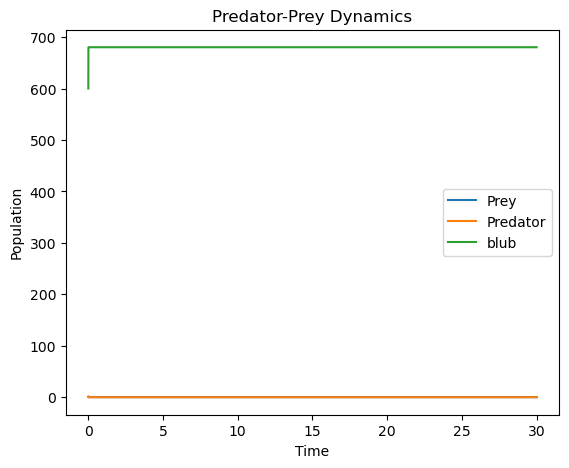

In [3]:
from project.models import CSTR3

# Initial Conditions
c0 = np.array([1.6/2, 2.4/2, 600])
t0, tf = 0, 30

# Instantiate and Solve
solver = DOPRI54(lambda t, y: CSTR3(t, y))
t_vals, y_vals = solver.integrate(t0, c0, tf)

# Plotting
plt.figure(figsize=(14, 5))

# Plot time series
plt.subplot(1, 2, 1)
plt.plot(t_vals, y_vals[:, 0], label='Prey', color='tab:blue')
plt.plot(t_vals, y_vals[:, 1], label='Predator', color='tab:orange')
plt.plot(t_vals, y_vals[:, 2], label='blub', color='tab:green')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Predator-Prey Dynamics')
plt.legend()

In [5]:
from scipy.integrate import solve_ivp

c0 = np.array([1.6/2, 2.4/2, 600])
res = solve_ivp(CSTR3, t_span=(0,30), y0=c0, t_eval=np.linspace(0,30,1000), method='RK45')

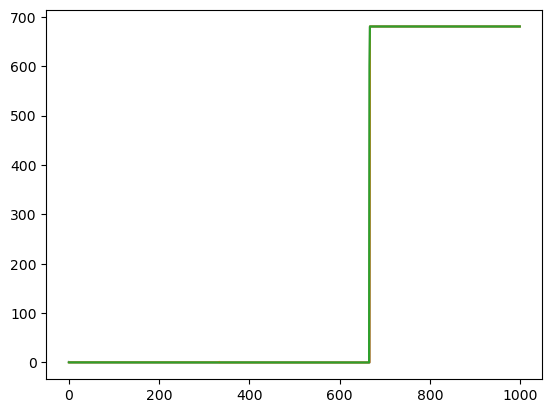

In [7]:
import matplotlib.pyplot as plt
plt.plot(res.y.reshape(-1,3))

In [9]:
res = solve_ivp(CSTR3, t_span=(0,30), y0=c0, t_eval=np.linspace(0,30,1000), method='BDF')

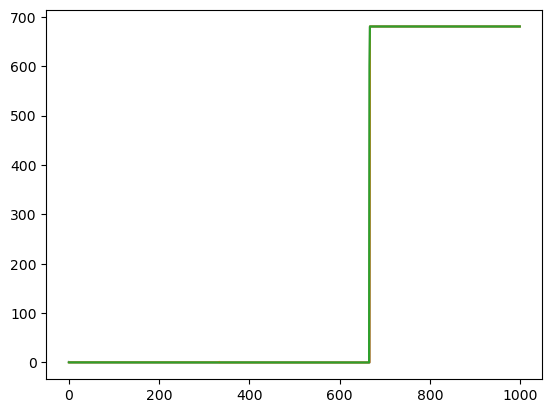

In [11]:
plt.plot(res.y.reshape(-1,3))